# SURE 2025 Speedy Simulations Kickoff
## Better Low Discrepancy Sequences

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

This notebook has been viewed (and perhaps modified) by
* Fred Hickernell
* Jimmy Nguyen

## Preliminaries

### If you running this in Jupyter notebook and you have the environment set up, ignore the cell below
### If are running this notebook in on Google colab, replace False in the next cell by True

In [1]:
if False:  #Running on colab? # If you are running this on colab
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !sudo apt install cm-super
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2025

### Import needed packages

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Traditional grids

### Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly
$$
x_i = i/n, \qquad i = 0, \ldots, n-1.
$$
These are leaning towards the left, but one may add a shift to center them,
$$
x_i = (i+1/2)/n, \qquad i = 0, \ldots, n-1.
$$
Unfortunately, it is not easy to **extend** the sequence of points by increasing $n$.  One must in general throw out the old points.

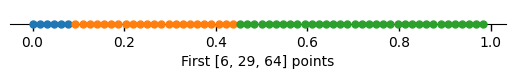

In [3]:
n_list = [6, 29, 64]  #the sample size used for these examples
xpts = np.linspace(0, 1-1./n_list[-1], n_list[-1]) #equally spaced points between 0 and 1
plt.style.use('default')
fig, ax = plt.subplots()
for ii,n in enumerate(n_list):
    n_start = 0 if ii == 0 else n_list[ii-1]
    ax.plot(xpts[n_start:n], np.zeros_like(xpts[n_start:n]), '.', markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
#ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
#ax.set_xlabel("$x_i$, ")
ax.set_xlabel(f"First {n_list} points")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.tick_params(axis='both', which='major', length=5, width=1)
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt,bbox_inches='tight')

### Grids in dimension $d > 1$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

The plots below show this effect.  Unfortunately, these grids are not 

In [4]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(0, 1.0-1/nper, nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

axis_pad = 0.05
def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = '', axis_pad = axis_pad, imgfrmt = 'pdf'):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False) 
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0-axis_pad,1+axis_pad])
    ax.set_ylim([0-axis_pad,1+axis_pad])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt)


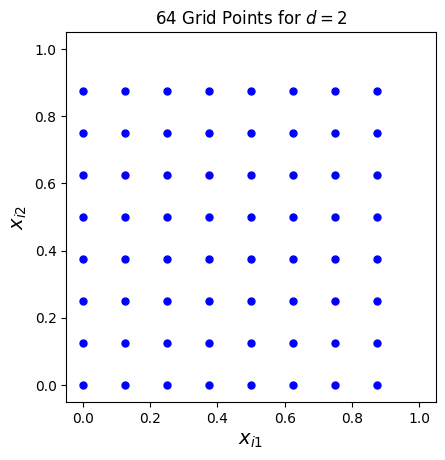

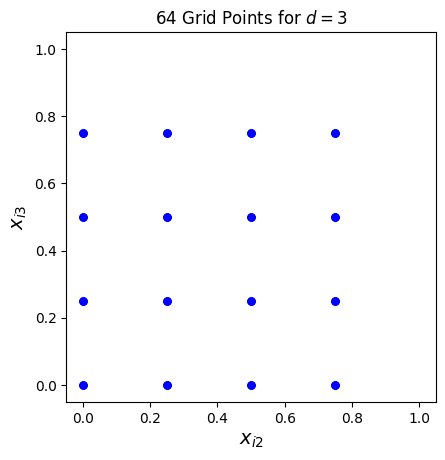

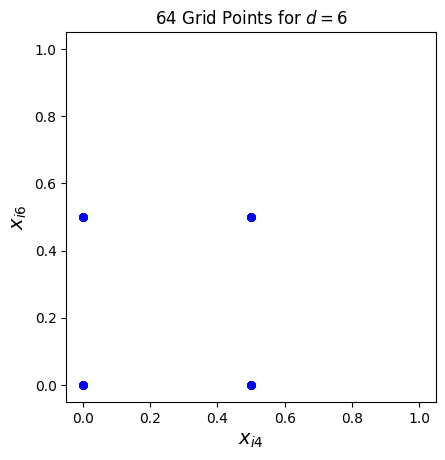

In [5]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [2,3], savefigs, figpath)
plot_grid(make_grid(6,2), [4,6], savefigs, figpath)

## Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

In [6]:
d = 6  #the dimension used for these examples
d_horiz = np.array([1])
d_vert = np.arange(2,5)
ms = 15

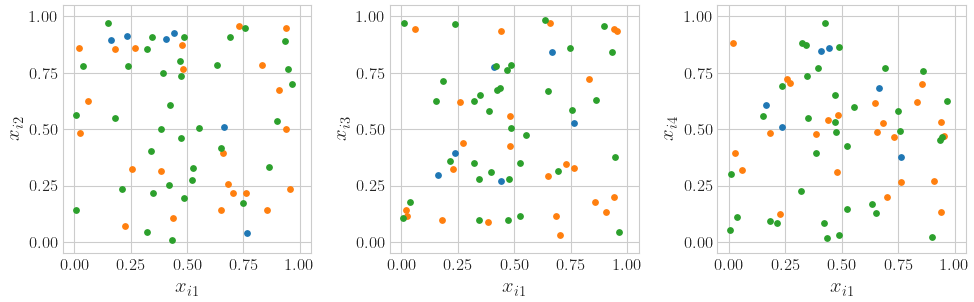

In [7]:
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n_list, d_horizontal = d_horiz, d_vertical = d_vert, figfac = 10, axis_pad = axis_pad, marker_size = ms, where_title = 0.55,fig_title = '')
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Low disrepancy sequences
There are several kinds of low discrepancy points, includng Sobol', lattice, Halton, and Kronecker.

### 1-dimensional low disrepancy sequences
We start with a one dimensional **extensible** sequence:
\begin{equation*}
\begin{aligned}
\textsf{van der Corput sequence} \quad & \phi_b((\cdots i_2 i_1 i_0)_b) = {}_b (0. i_0 i_1 i_2 \cdots) \\
\textsf{e.g. } & \phi_2(6) = \phi_2(110_2) = {}_2 0. 011 = 3/8
\end{aligned}
\end{equation*}
We and add a shift as well:
\begin{equation*}
x_i = \phi_b(i) + \Delta \bmod 1, \qquad i = 0, 1, 2, \ldots
\end{equation*}

Below we display one kind.

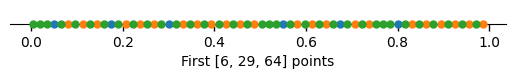

In [8]:
delta = 0.05  #the spacing between the points
xpts = np.mod(qp.DigitalNetB2(dimension=1,randomize=False).gen_samples(n_max=n_list[-1],warn=False) + delta,1) #generate a van de Corput sequence and add a shift
plt.style.use('default')
fig, ax = plt.subplots(1)
for ii,n in enumerate(n_list):
    n_start = 0 if ii == 0 else n_list[ii-1]
    ax.plot(xpts[n_start:n], np.zeros_like(xpts[n_start:n]), '.', markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_aspect(1)
ax.set_xlabel(f"First {n_list} points")
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.tick_params(axis='both', which='major', length=5, width=1)
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}VDCpts."+imgfrmt,format=imgfrmt,bbox_inches='tight')

### $d$-Dimensional integration lattices with a shift

\begin{equation*}
\boldsymbol{x}_i = \phi_b(i) \boldsymbol{h} + \boldsymbol{\Delta} \bmod \boldsymbol{1}, \qquad i = 0, 1, 2, \ldots
\end{equation*}


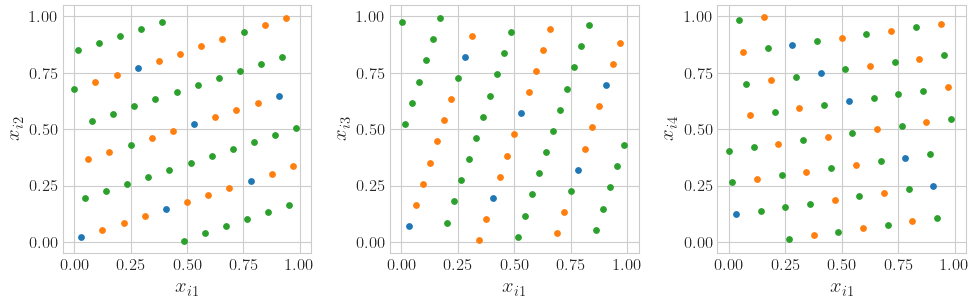

In [9]:
fig,ax = qp.plot_proj(qp.Lattice(d), n=n_list, d_horizontal = d_horiz, d_vertical = d_vert, figfac = 10, axis_pad = axis_pad, where_title = 0.55,marker_size=ms,fig_title = '')
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}lattice_pts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### $d$-Dimensional Kronecker sequence with a shift

\begin{equation*}
\boldsymbol{x}_i = i \boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}, \qquad i = 0, 1, 2, \ldots
\end{equation*}

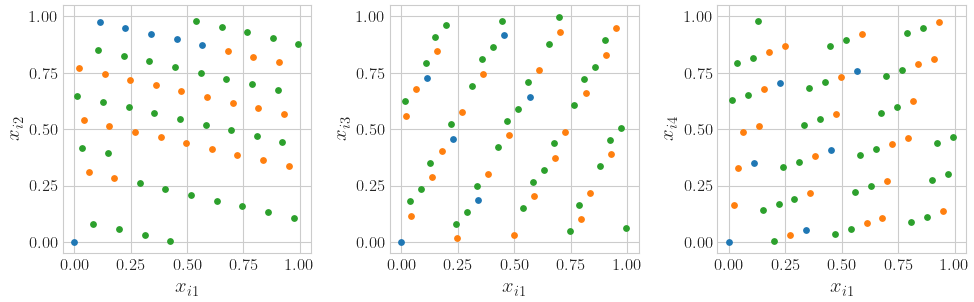

In [10]:
np.random.seed(47)
fig,ax = qp.plot_proj(qp.Kronecker(d,alpha = np.random.rand(d)), n=n_list, d_horizontal = d_horiz, d_vertical = d_vert, figfac = 10, axis_pad = axis_pad, where_title = 0.55,marker_size=ms,fig_title = '')
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}kronecker_pts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### $d$-Dimensional Halton sequence

\begin{equation*}
\boldsymbol{x}_i = \bigl(\phi_{b_1}(i), \ldots, \phi_{b_d}(i) \bigr), \qquad i = 0, 1, 2, \ldots, \quad b_1 = 2, b_2 = 3, b_3 = 5, b_4 = 7, \ldots
\end{equation*}

/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/discrete_distribution/halton.py:228


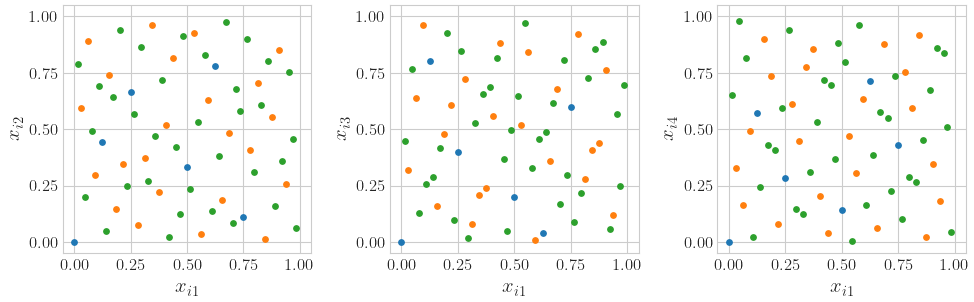

In [11]:
fig,ax = qp.plot_proj(qp.Halton(d, randomize = "FALSE"), n = n_list, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, axis_pad = axis_pad, marker_size=ms, where_title = 0.55, fig_title = "")
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}haltonpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### $d$-Dimensional Sobol' sequence

Scramble the digits of the $b=2$ van der Corput sequence for each coordinate

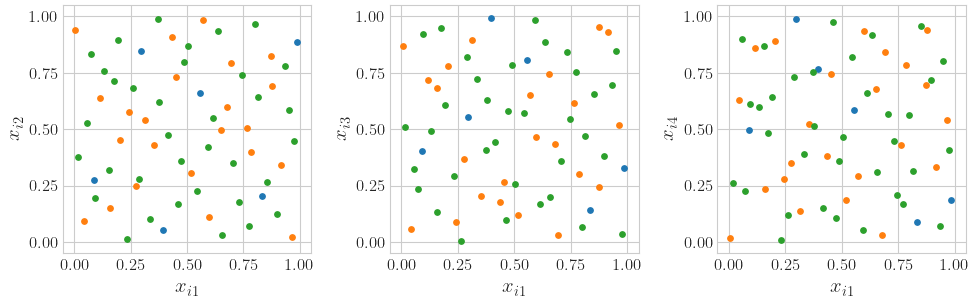

In [12]:
fig,ax = qp.plot_proj(qp.Sobol(d), n = n_list, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, axis_pad = axis_pad, marker_size = ms, where_title = 0.55, fig_title = "")
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Research Questions
<ul style="font-size:20px;">
<li>How well do Kronecker and lattice perform for non-preferred sample sizes?</li>
<li>How do we find a good generator $\boldsymbol{\alpha}$ for Kronecker?</li>
<li>Is there some generalization of Kronecker and lattice sequences that includes both?</li>
</ul>

## Kernel based discrepancies and random shifts leading to periodic kernels

One definition of discrepancy starts with a symmetric, positive definite kernel, $K:[0,1]^d\times [0,1]^d \to \mathbb{R}$, i.e.,
\begin{gather*}
K(\boldsymbol{t},\boldsymbol{x}) = K(\boldsymbol{x},\boldsymbol{t}) \qquad \forall \boldsymbol{t}, \boldsymbol{x} \in [0,1]^d \\
\sum_{i,j = 1}^{n} c_i K(\boldsymbol{x}_i,\boldsymbol{x}_j ) \boldsymbol{c}_j > 0 \qquad \forall \boldsymbol{c} \ne \boldsymbol{0}, \ \boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \text{ distinct and } \in [0,1]^d
\end{gather*}
The discrepancy, $D(\{\boldsymbol{x}\}_{i=1}^n)$ is defined in terms of the kernel as
$$
[D(\{\boldsymbol{x}_i\}_{i=1}^n,K)]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x}
- \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(\boldsymbol{t}, \boldsymbol{x}_i) \, \mathrm{d}\boldsymbol{t}
+ \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
The discrepancy requires $\mathcal{O}(dn^2)$ operations to compute, assuming one evaluation of the kernel requires $d$ operations to compute.

Now suppose that we take a set of nodes, $\{\boldsymbol{x}\}_{i=1}^n$, and we add the same random shift, $\boldsymbol{\Delta}$, modulo $\boldsymbol{1}$ to each node.  The root mean squared discrepancy is
$$
\begin{aligned}
\mathbb{E}\{[D(\{\boldsymbol{x}_i + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x}  - \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t}, \boldsymbol{x}_i + \boldsymbol{z} \bmod \boldsymbol{1}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{z} \\
& \qquad + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} K(\boldsymbol{x}_i + \boldsymbol{z} \bmod \boldsymbol{1}, \boldsymbol{x}_j + \boldsymbol{z} \bmod \boldsymbol{1}) \, \mathrm{d}\boldsymbol{z} \\
& = - \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x} + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} K(\boldsymbol{x}_i - \boldsymbol{x}_j + \boldsymbol{z} \bmod \boldsymbol{1},\boldsymbol{z} ) \, \mathrm{d}\boldsymbol{z} \\
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} + \frac{1}{n^2} \sum_{i,j = 1}^n  \widetilde{K}(\boldsymbol{x}_i - \boldsymbol{x}_j \bmod \boldsymbol{1}), \qquad \text{where }  \, \widetilde{K}(\boldsymbol{t}) : = \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{x} \\
&= [D(\{\boldsymbol{x}_i\}_{i=1}^n,\widehat{K})]^2 \qquad \text{for } \widehat{K}(\boldsymbol{t},\boldsymbol{x}) : = \int_{[0,1]^d} K((\boldsymbol{t} + \boldsymbol{z} \bmod \boldsymbol{1}, \boldsymbol{x} + \boldsymbol{z} \bmod \boldsymbol{1}) \, \mathrm{d} \boldsymbol{z}
\end{aligned}
$$
This has the same cost to compute but a somewhat simpler form.


### Periodic kernels for Kronecker and lattice sequences

Now, let's evaluate the formula for the discrepancy for a randomly shifted Kronecker and lattice sequence:
\begin{equation*}
\begin{aligned}
\text{Kronecker: } \mathbb{E}\{[D(\{i\boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} \widetilde{K}((i - j)\boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
&=  - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} 
+ \frac 1{n^2} \sum_{k=1-n}^{n-1}  (n -  \lvert k \rvert)\widetilde{K}(k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t}
+ \frac 1{n^2} \biggl[n \widetilde{K}(\boldsymbol{0}) +  2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \biggr] \\
\text{lattice: } \mathbb{E}\{[D(\{\phi_b(i)\boldsymbol{h} + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = ??
\end{aligned}
\end{equation*}

### Weighted Sum of Squares of Discrepancy

In [13]:
print("finished running notebook")

finished running notebook
